In [1]:
!git clone https://github.com/nevinbaiju/latent_diffusion-mnist.git
%cd latent_diffusion-mnist

Cloning into 'latent_diffusion-mnist'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 5), reused 22 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 192.28 KiB | 38.46 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/latent_diffusion-mnist


In [2]:
!pip install torch numpy tqdm matplotlib diffusers[torch] transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
img_size = 32 # MNIST 32x32로 resize

latent_channels = 4 # latent space channel 수

# VAE training 설정
lr_vae = 1e-4
vae_epochs = 50

# UNet training 및 DDPM 설정
lr_unet = 1e-4
denoising_timesteps = 1000
num_warmup_steps = 500
unet_epochs = 100

vae_model_path = 'models/vae.pth'
unet_model_path = 'models/unet.pth'

vae_plots_path = 'plots/vae/'
unet_plots_path = 'plots/unet/'

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((img_size, img_size))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:11<00:00, 897kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.15MB/s]


In [6]:
# models.py
from diffusers import UNet2DConditionModel, AutoencoderKL

# AutoencoderKL: encoder + decoder (VAE)
vae = AutoencoderKL(
    in_channels=1,
    out_channels=1,
    latent_channels=latent_channels,
    sample_size=32,
    block_out_channels=(16, 32, 64),
    norm_num_groups=4,
    down_block_types=("DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D",),
    up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D")
).to(device)

# UNet2DConditionModel: noise 예측 네트워크 (DDPM에서 ε 예측 역할)
unet = UNet2DConditionModel(
    in_channels=latent_channels,
    out_channels=latent_channels,
    sample_size=8,  # latent 크기 (32/4 = 8)

    layers_per_block=2,
    down_block_types=('AttnDownBlock2D', 'AttnDownBlock2D'),
    up_block_types=('AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels=(128, 256),
    norm_num_groups=1,

    num_class_embeds=10, # class-conditioning (MNIST: 0~9)
    time_embedding_act_fn='silu',
    cross_attention_dim=256, # cross-attn 차원 (encoder_hidden_states용, 현재는 사용 안 함)
    class_embeddings_concat=True, # class embedding을 concat 방식으로 사용
).to(device)

In [12]:
# utils.py
from diffusers import DDPMScheduler

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

def create_path_if_not_exists(path: str): # 폴더 없으면 생성
    if not os.path.exists(path):
        os.mkdir(path)

def revert_images(imgs: torch.tensor) -> np.array:
    """
    모델 출력을 0~255 범위로 정규화하여 시각화에 적합하게 변환
    - 입력: (B, C, H, W) 형태의 텐서 이미지
    - 출력: numpy 형식의 이미지 (int형, 0~255 스케일)

    기본적으로 grayscale (C=1) 처리를 고려
    """
    h = imgs.shape[-1]
    imgs = imgs.cpu().detach().numpy()
    min_vals = imgs.min(axis=(1, 2, 3))[:, np.newaxis, np.newaxis, np.newaxis]
    max_vals = imgs.max(axis=(1, 2, 3))[:, np.newaxis, np.newaxis, np.newaxis]

    imgs = ((max_vals - imgs)/(max_vals-min_vals))*255
    if imgs.shape[1] == 1: # grayscale이면 채널 차원 제거
        imgs = imgs.astype(int).reshape(-1, h, h)

    return imgs

def plot_side_by_side(images_y: torch.tensor, images_pred: torch.tensor,
                      latents: torch.tensor, epoch: int):
    """
    VAE 성능을 시각화하는 함수
    - 입력 이미지, 복원 이미지, latent 채널을 한눈에 비교 가능
    - 각 epoch마다 PNG 파일로 저장됨
    """

    images_y, images_pred = revert_images(images_y), revert_images(images_pred)
    latents = revert_images(latents)
    idx = np.random.randint(0, images_y.shape[0])
    fig, axs = plt.subplots(1, 2)

    # Plot input image and Output image
    axs[0].imshow(images_y[idx], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Input")

    axs[1].imshow(images_pred[idx], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Output")
    plt.savefig(os.path.join(vae_plots_path, f'epoch_{epoch}_input_output.png'))
    plt.clf()

    latent_channels = latents.shape[1]
    fig, axs = plt.subplots(1, 4)

    # Plot the different latent channels
    for i in range(latent_channels):
        axs[i].imshow(latents[idx, i, :, :], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Latent channel: {i}", fontsize=8)
    plt.savefig(os.path.join(vae_plots_path, f'epoch_{epoch}_latent_channels.png'))
    plt.clf()

def generate(vae: torch.nn.Module, unet: torch.nn.Module, noise_scheduler: DDPMScheduler, epoch: int):
    """
    학습된 VAE + UNet 모델을 이용하여 latent space에서 이미지를 생성하는 함수
    - noise → denoise 과정을 반복하며 복원 이미지 생성
    - 지정된 timestep마다 샘플 이미지 저장
    """
    # 처음 latent z를 랜덤 noise에서 시작하여 t=1000부터 denoise 진행
    def plot(recon_imgs, timesteps, epoch):
        """
        각 timestep의 복원 결과를 저장하는 내부 함수
        """
        create_path_if_not_exists(os.path.join(unet_plots_path, f'epoch_{epoch}'))
        recon_imgs = revert_images(recon_imgs.sample)
        fig, axs = plt.subplots(2, 5)
        for i in range(10):
            axs[i//5][i%5].imshow(recon_imgs[i], cmap='gray')
            axs[i//5][i%5].axis('off')
            axs[i//5][i%5].set_title(str(i))
        plt.suptitle(f"Timesteps: {timesteps}")
        plt.savefig(os.path.join(unet_plots_path, f'epoch_{epoch}', f'plot {timesteps}.png'))
        plt.clf()
        plt.close()

    # (1) 랜덤 latent vector 생성 (noise)
    latents = torch.randn((10, latent_channels, 8, 8)).to(device)
    labels = torch.arange(10).to(device) # (2) MNIST 클래스 조건: 0~9까지 정수 레이블 부여

    # (3) DDPM reverse process (T → 0)
    for t in tqdm(noise_scheduler.timesteps):
        with torch.no_grad():
            # UNet을 통해 현재 timestep에서의 노이즈 예측
            noise_pred = unet(latents, t, class_labels=labels, encoder_hidden_states=None).sample
            # 예측된 노이즈를 이용해 한 스텝 denoise
            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
            # 일정 간격 또는 마지막 timestep에서 이미지 저장
            recon_imgs = vae.decode(latents)
            if t == 999 or t%100 == 0:
                plot(recon_imgs, t, epoch)

In [8]:
# train.py
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.training_utils import EMAModel
from accelerate import Accelerator

def train_vae():
    """
    AutoencoderKL (VAE) 학습
    - reconstruction loss (MSE) + KL divergence 기반
    - 학습된 latent 공간 생성
    """
    vae_optimizer = torch.optim.AdamW(vae.parameters(), lr=lr_vae)
    for epoch in range(vae_epochs):
        losses = []
        for step, (images, _) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            vae_optimizer.zero_grad()

            # VAE forward pass
            posterior = vae.encode(images)
            outputs = vae.decode(posterior['latent_dist'].sample())
            # Compute VAE loss
            recon_loss = F.mse_loss(outputs.sample, images, reduction="mean")
            kl_loss = (posterior.latent_dist.kl()/(batch_size*img_size*img_size)).mean()
            vae_loss = recon_loss + 0.5*kl_loss

            losses.append(vae_loss.item())
            vae_loss.backward()
            vae_optimizer.step()

        print(f"VAE Epoch {epoch+1}, Loss: {np.mean(losses):.4f}")
        plot_side_by_side(images, outputs.sample, posterior.latent_dist.sample(), epoch+1)
        with torch.no_grad():
            losses = []
            for step, (images, _) in enumerate(tqdm(test_loader)):
                images = images.to(device)

                # VAE forward pass
                posterior = vae.encode(images)
                outputs = vae.decode(posterior['latent_dist'].sample())
                # Compute VAE loss
                recon_loss = F.mse_loss(outputs.sample, images, reduction="mean")
                kl_loss = (posterior.latent_dist.kl()/(64*28*28)).mean()
                vae_loss = recon_loss + 0.5*kl_loss

                losses.append(vae_loss.item())
        print(f"VAE Epoch {epoch+1}, Test Loss: {np.mean(losses):.4f}")

    torch.save(vae.state_dict(), vae_model_path)

def train_unet():
    """
    DDPM 기반 UNet 학습
    - 목표: latent 공간에서 노이즈를 제거하는 모델 학습 (noise prediction)
    - class-conditional diffusion 적용
    """
    vae.load_state_dict(torch.load(vae_model_path)) # 학습된 VAE 로드
    noise_scheduler = DDPMScheduler(num_train_timesteps=denoising_timesteps)
    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr_unet)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=(len(train_loader) * 100),
    )

    # 분산 학습/메모리 최적화 설정
    accelerator = Accelerator()
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_loader, lr_scheduler
    )
    # EMA: 모델 파라미터 지수 평균 추적 → 안정적 샘플링에 도움
    ema_model = EMAModel(model.parameters(), decay=0.9999, use_ema_warmup=True)
    for epoch in range(100):

        losses = []
        for step, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            labels_raw = labels
            latents = vae.encode(images).latent_dist.sample() # 1. latent 생성
            noise = torch.randn(latents.shape).to(device) # 2. 동일 shape의 표준 정규분포 노이즈 생성
            bs = images.shape[0]

            # 3. 랜덤 timestep 샘플링 (batch마다 다름)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()

            # 4. latent에 noise 추가
            noisy_images = noise_scheduler.add_noise(latents, noise, timesteps)

            # 5. UNet이 noise를 예측하도록 학습
            optimizer.zero_grad()
            noise_pred =  unet(sample=noisy_images, timestep=timesteps, encoder_hidden_states=None, class_labels=labels)
            noise_pred = noise_pred.sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            ema_model.step(model.parameters())

            losses.append(loss.item())

        print(f'Epoch: {epoch+1}, Train loss: {np.mean(losses)}')
        generate(vae, unet, noise_scheduler, epoch)

        losses = []
        with torch.no_grad():
            for step, (images, labels) in enumerate(tqdm(test_loader)):
                images = images.to(device)
                labels = labels.to(device)
                latents = vae.encode(images).latent_dist.sample()
                noise = torch.randn(latents.shape).to(device)
                bs = images.shape[0]

                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()

                # Add noise to the clean images according to the noise magnitude at each timestep
                noisy_images = noise_scheduler.add_noise(latents, noise, timesteps)

                noise_pred =  unet(sample=noisy_images, timestep=timesteps, encoder_hidden_states=None, class_labels=labels)
                noise_pred = noise_pred.sample
                loss = torch.nn.functional.mse_loss(noise_pred, noise)

                losses.append(loss.item())

        print(f'Epoch: {epoch+1}, Test loss: {np.mean(losses)}')
    torch.save(unet.state_dict(), unet_model_path)

def train():
    """
    전체 학습 실행 함수
    - 경로를 생성하고, 모델이 없으면 학습 실행
    """
    create_path_if_not_exists('models')
    create_path_if_not_exists('plots')
    create_path_if_not_exists(vae_plots_path)
    create_path_if_not_exists(unet_plots_path)

    if not os.path.exists(vae_model_path):
        train_vae()

    if not os.path.exists(unet_model_path):
        train_unet()


if __name__ == "__main__":
    train()

100%|██████████| 938/938 [00:46<00:00, 20.11it/s]


VAE Epoch 1, Loss: 0.0436


100%|██████████| 157/157 [00:04<00:00, 32.57it/s]


VAE Epoch 1, Test Loss: 0.0132


100%|██████████| 938/938 [00:45<00:00, 20.80it/s]


VAE Epoch 2, Loss: 0.0106


100%|██████████| 157/157 [00:04<00:00, 32.58it/s]


VAE Epoch 2, Test Loss: 0.0096


100%|██████████| 938/938 [00:45<00:00, 20.81it/s]


VAE Epoch 3, Loss: 0.0081


100%|██████████| 157/157 [00:04<00:00, 32.87it/s]


VAE Epoch 3, Test Loss: 0.0081


100%|██████████| 938/938 [00:45<00:00, 20.78it/s]


VAE Epoch 4, Loss: 0.0068


100%|██████████| 157/157 [00:04<00:00, 33.24it/s]


VAE Epoch 4, Test Loss: 0.0069


100%|██████████| 938/938 [00:44<00:00, 20.86it/s]


VAE Epoch 5, Loss: 0.0060


100%|██████████| 157/157 [00:04<00:00, 32.98it/s]


VAE Epoch 5, Test Loss: 0.0061


100%|██████████| 938/938 [00:45<00:00, 20.78it/s]


VAE Epoch 6, Loss: 0.0054


100%|██████████| 157/157 [00:04<00:00, 33.30it/s]


VAE Epoch 6, Test Loss: 0.0058


100%|██████████| 938/938 [00:45<00:00, 20.79it/s]


VAE Epoch 7, Loss: 0.0049


100%|██████████| 157/157 [00:04<00:00, 32.94it/s]


VAE Epoch 7, Test Loss: 0.0052


100%|██████████| 938/938 [00:45<00:00, 20.68it/s]


VAE Epoch 8, Loss: 0.0046


100%|██████████| 157/157 [00:04<00:00, 33.28it/s]


VAE Epoch 8, Test Loss: 0.0049


100%|██████████| 938/938 [00:44<00:00, 21.06it/s]


VAE Epoch 9, Loss: 0.0044


100%|██████████| 157/157 [00:04<00:00, 33.56it/s]


VAE Epoch 9, Test Loss: 0.0047


100%|██████████| 938/938 [00:44<00:00, 20.91it/s]


VAE Epoch 10, Loss: 0.0042


100%|██████████| 157/157 [00:04<00:00, 33.14it/s]


VAE Epoch 10, Test Loss: 0.0046


100%|██████████| 938/938 [00:45<00:00, 20.73it/s]
<ipython-input-7-cbc20d276e94>:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2)


VAE Epoch 11, Loss: 0.0040


100%|██████████| 157/157 [00:04<00:00, 33.28it/s]


VAE Epoch 11, Test Loss: 0.0045


100%|██████████| 938/938 [00:45<00:00, 20.56it/s]


VAE Epoch 12, Loss: 0.0039


100%|██████████| 157/157 [00:04<00:00, 32.72it/s]


VAE Epoch 12, Test Loss: 0.0045


100%|██████████| 938/938 [00:45<00:00, 20.58it/s]


VAE Epoch 13, Loss: 0.0038


100%|██████████| 157/157 [00:04<00:00, 33.11it/s]


VAE Epoch 13, Test Loss: 0.0042


100%|██████████| 938/938 [00:45<00:00, 20.83it/s]


VAE Epoch 14, Loss: 0.0037


100%|██████████| 157/157 [00:04<00:00, 33.12it/s]


VAE Epoch 14, Test Loss: 0.0042


100%|██████████| 938/938 [00:44<00:00, 20.88it/s]


VAE Epoch 15, Loss: 0.0036


100%|██████████| 157/157 [00:04<00:00, 32.88it/s]


VAE Epoch 15, Test Loss: 0.0040


100%|██████████| 938/938 [00:44<00:00, 20.88it/s]


VAE Epoch 16, Loss: 0.0035


100%|██████████| 157/157 [00:04<00:00, 32.99it/s]


VAE Epoch 16, Test Loss: 0.0039


100%|██████████| 938/938 [00:44<00:00, 20.91it/s]


VAE Epoch 17, Loss: 0.0034


100%|██████████| 157/157 [00:04<00:00, 32.75it/s]


VAE Epoch 17, Test Loss: 0.0042


100%|██████████| 938/938 [00:45<00:00, 20.82it/s]


VAE Epoch 18, Loss: 0.0034


100%|██████████| 157/157 [00:04<00:00, 33.01it/s]


VAE Epoch 18, Test Loss: 0.0038


100%|██████████| 938/938 [00:46<00:00, 20.23it/s]


VAE Epoch 19, Loss: 0.0033


100%|██████████| 157/157 [00:04<00:00, 32.64it/s]


VAE Epoch 19, Test Loss: 0.0038


100%|██████████| 938/938 [00:45<00:00, 20.42it/s]


VAE Epoch 20, Loss: 0.0033


100%|██████████| 157/157 [00:04<00:00, 32.23it/s]


VAE Epoch 20, Test Loss: 0.0037


100%|██████████| 938/938 [00:45<00:00, 20.41it/s]


VAE Epoch 21, Loss: 0.0033


100%|██████████| 157/157 [00:04<00:00, 33.18it/s]


VAE Epoch 21, Test Loss: 0.0037


100%|██████████| 938/938 [00:46<00:00, 20.34it/s]


VAE Epoch 22, Loss: 0.0032


100%|██████████| 157/157 [00:04<00:00, 32.38it/s]


VAE Epoch 22, Test Loss: 0.0036


100%|██████████| 938/938 [00:46<00:00, 20.37it/s]


VAE Epoch 23, Loss: 0.0032


100%|██████████| 157/157 [00:04<00:00, 32.41it/s]


VAE Epoch 23, Test Loss: 0.0036


100%|██████████| 938/938 [00:45<00:00, 20.65it/s]


VAE Epoch 24, Loss: 0.0032


100%|██████████| 157/157 [00:04<00:00, 32.44it/s]


VAE Epoch 24, Test Loss: 0.0036


100%|██████████| 938/938 [00:45<00:00, 20.48it/s]


VAE Epoch 25, Loss: 0.0031


100%|██████████| 157/157 [00:04<00:00, 32.31it/s]


VAE Epoch 25, Test Loss: 0.0035


100%|██████████| 938/938 [00:45<00:00, 20.39it/s]


VAE Epoch 26, Loss: 0.0031


100%|██████████| 157/157 [00:04<00:00, 32.54it/s]


VAE Epoch 26, Test Loss: 0.0035


100%|██████████| 938/938 [00:46<00:00, 20.36it/s]


VAE Epoch 27, Loss: 0.0031


100%|██████████| 157/157 [00:04<00:00, 32.30it/s]


VAE Epoch 27, Test Loss: 0.0036


100%|██████████| 938/938 [00:46<00:00, 20.37it/s]


VAE Epoch 28, Loss: 0.0030


100%|██████████| 157/157 [00:04<00:00, 32.92it/s]


VAE Epoch 28, Test Loss: 0.0035


100%|██████████| 938/938 [00:46<00:00, 20.38it/s]


VAE Epoch 29, Loss: 0.0030


100%|██████████| 157/157 [00:04<00:00, 32.54it/s]


VAE Epoch 29, Test Loss: 0.0035


100%|██████████| 938/938 [00:45<00:00, 20.43it/s]


VAE Epoch 30, Loss: 0.0030


100%|██████████| 157/157 [00:04<00:00, 32.60it/s]


VAE Epoch 30, Test Loss: 0.0034


100%|██████████| 938/938 [00:45<00:00, 20.40it/s]


VAE Epoch 31, Loss: 0.0030


100%|██████████| 157/157 [00:04<00:00, 32.53it/s]


VAE Epoch 31, Test Loss: 0.0034


100%|██████████| 938/938 [00:46<00:00, 20.39it/s]


VAE Epoch 32, Loss: 0.0030


100%|██████████| 157/157 [00:04<00:00, 32.33it/s]


VAE Epoch 32, Test Loss: 0.0034


100%|██████████| 938/938 [00:45<00:00, 20.68it/s]


VAE Epoch 33, Loss: 0.0029


100%|██████████| 157/157 [00:04<00:00, 32.78it/s]


VAE Epoch 33, Test Loss: 0.0033


100%|██████████| 938/938 [00:44<00:00, 20.86it/s]


VAE Epoch 34, Loss: 0.0029


100%|██████████| 157/157 [00:04<00:00, 32.14it/s]


VAE Epoch 34, Test Loss: 0.0033


100%|██████████| 938/938 [00:45<00:00, 20.52it/s]


VAE Epoch 35, Loss: 0.0029


100%|██████████| 157/157 [00:04<00:00, 32.59it/s]


VAE Epoch 35, Test Loss: 0.0033


100%|██████████| 938/938 [00:45<00:00, 20.55it/s]


VAE Epoch 36, Loss: 0.0029


100%|██████████| 157/157 [00:04<00:00, 33.09it/s]


VAE Epoch 36, Test Loss: 0.0033


100%|██████████| 938/938 [00:45<00:00, 20.67it/s]


VAE Epoch 37, Loss: 0.0029


100%|██████████| 157/157 [00:04<00:00, 32.50it/s]


VAE Epoch 37, Test Loss: 0.0033


100%|██████████| 938/938 [00:45<00:00, 20.61it/s]


VAE Epoch 38, Loss: 0.0029


100%|██████████| 157/157 [00:04<00:00, 32.63it/s]


VAE Epoch 38, Test Loss: 0.0033


100%|██████████| 938/938 [00:45<00:00, 20.76it/s]


VAE Epoch 39, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 33.09it/s]


VAE Epoch 39, Test Loss: 0.0033


100%|██████████| 938/938 [00:45<00:00, 20.56it/s]


VAE Epoch 40, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 33.02it/s]


VAE Epoch 40, Test Loss: 0.0033


100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


VAE Epoch 41, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 33.50it/s]


VAE Epoch 41, Test Loss: 0.0032


100%|██████████| 938/938 [00:45<00:00, 20.58it/s]


VAE Epoch 42, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 32.66it/s]


VAE Epoch 42, Test Loss: 0.0032


100%|██████████| 938/938 [00:45<00:00, 20.58it/s]


VAE Epoch 43, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 32.77it/s]


VAE Epoch 43, Test Loss: 0.0032


100%|██████████| 938/938 [00:45<00:00, 20.62it/s]


VAE Epoch 44, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 33.03it/s]


VAE Epoch 44, Test Loss: 0.0032


100%|██████████| 938/938 [00:45<00:00, 20.51it/s]


VAE Epoch 45, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 32.82it/s]


VAE Epoch 45, Test Loss: 0.0032


100%|██████████| 938/938 [00:45<00:00, 20.62it/s]


VAE Epoch 46, Loss: 0.0028


100%|██████████| 157/157 [00:04<00:00, 33.12it/s]


VAE Epoch 46, Test Loss: 0.0032


100%|██████████| 938/938 [00:45<00:00, 20.65it/s]


VAE Epoch 47, Loss: 0.0027


100%|██████████| 157/157 [00:04<00:00, 32.71it/s]


VAE Epoch 47, Test Loss: 0.0032


100%|██████████| 938/938 [00:45<00:00, 20.66it/s]


VAE Epoch 48, Loss: 0.0027


100%|██████████| 157/157 [00:04<00:00, 33.17it/s]


VAE Epoch 48, Test Loss: 0.0031


100%|██████████| 938/938 [00:45<00:00, 20.66it/s]


VAE Epoch 49, Loss: 0.0027


100%|██████████| 157/157 [00:04<00:00, 33.11it/s]


VAE Epoch 49, Test Loss: 0.0031


100%|██████████| 938/938 [00:45<00:00, 20.69it/s]


VAE Epoch 50, Loss: 0.0027


100%|██████████| 157/157 [00:04<00:00, 33.12it/s]


VAE Epoch 50, Test Loss: 0.0031


100%|██████████| 938/938 [01:26<00:00, 10.90it/s]


Epoch: 1, Train loss: 0.354314433216159


100%|██████████| 157/157 [00:06<00:00, 23.81it/s]


Epoch: 1, Test loss: 0.2683312954606524


100%|██████████| 938/938 [01:27<00:00, 10.77it/s]


Epoch: 2, Train loss: 0.2668354819610175


100%|██████████| 157/157 [00:06<00:00, 23.56it/s]


Epoch: 2, Test loss: 0.2610646354354871


100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch: 3, Train loss: 0.26462427070781364


100%|██████████| 157/157 [00:06<00:00, 23.88it/s]


Epoch: 3, Test loss: 0.2607131123922433


100%|██████████| 938/938 [01:27<00:00, 10.77it/s]


Epoch: 4, Train loss: 0.25976057871699587


100%|██████████| 157/157 [00:06<00:00, 23.66it/s]


Epoch: 4, Test loss: 0.25973564244000014


100%|██████████| 938/938 [01:27<00:00, 10.78it/s]


Epoch: 5, Train loss: 0.26235197263676474


100%|██████████| 157/157 [00:06<00:00, 23.34it/s]


Epoch: 5, Test loss: 0.2655200250209517


100%|██████████| 938/938 [01:27<00:00, 10.72it/s]


Epoch: 6, Train loss: 0.25927085933019356


100%|██████████| 157/157 [00:06<00:00, 23.54it/s]


Epoch: 6, Test loss: 0.2621549488442719


100%|██████████| 938/938 [01:27<00:00, 10.72it/s]


Epoch: 7, Train loss: 0.25832901566203975


100%|██████████| 157/157 [00:06<00:00, 23.56it/s]


Epoch: 7, Test loss: 0.2559046089459377


100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch: 8, Train loss: 0.2583576011251031


100%|██████████| 157/157 [00:06<00:00, 23.75it/s]


Epoch: 8, Test loss: 0.25884863572895145


100%|██████████| 938/938 [01:27<00:00, 10.73it/s]


Epoch: 9, Train loss: 0.25700043214917945


100%|██████████| 157/157 [00:06<00:00, 23.48it/s]


Epoch: 9, Test loss: 0.25715120763156063


100%|██████████| 938/938 [01:27<00:00, 10.73it/s]


Epoch: 10, Train loss: 0.2544488082212934


100%|██████████| 157/157 [00:06<00:00, 23.74it/s]


Epoch: 10, Test loss: 0.25875585322167466


100%|██████████| 938/938 [01:27<00:00, 10.73it/s]


Epoch: 11, Train loss: 0.25469796262633826


100%|██████████| 157/157 [00:06<00:00, 23.54it/s]


Epoch: 11, Test loss: 0.2554846200973365


100%|██████████| 938/938 [01:26<00:00, 10.78it/s]


Epoch: 12, Train loss: 0.2550713397673707


100%|██████████| 157/157 [00:06<00:00, 23.69it/s]


Epoch: 12, Test loss: 0.25578427238828816


100%|██████████| 938/938 [01:27<00:00, 10.77it/s]


Epoch: 13, Train loss: 0.25494640090191034


100%|██████████| 157/157 [00:06<00:00, 23.75it/s]


Epoch: 13, Test loss: 0.25518947488563076


100%|██████████| 938/938 [01:28<00:00, 10.65it/s]


Epoch: 14, Train loss: 0.25346663710214434


100%|██████████| 157/157 [00:06<00:00, 23.77it/s]


Epoch: 14, Test loss: 0.26124753057956696


100%|██████████| 938/938 [01:27<00:00, 10.71it/s]


Epoch: 15, Train loss: 0.25613186835670776


100%|██████████| 157/157 [00:06<00:00, 23.51it/s]


Epoch: 15, Test loss: 0.2535302686463496


100%|██████████| 938/938 [01:27<00:00, 10.72it/s]


Epoch: 16, Train loss: 0.25323032265278833


100%|██████████| 157/157 [00:06<00:00, 23.72it/s]


Epoch: 16, Test loss: 0.2556660834011758


100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch: 17, Train loss: 0.25349358075272554


100%|██████████| 157/157 [00:06<00:00, 23.52it/s]


Epoch: 17, Test loss: 0.24868727935727236


100%|██████████| 938/938 [01:27<00:00, 10.69it/s]


Epoch: 18, Train loss: 0.2534936725267215


100%|██████████| 157/157 [00:06<00:00, 23.33it/s]


Epoch: 18, Test loss: 0.25092443596025943


100%|██████████| 938/938 [01:27<00:00, 10.71it/s]


Epoch: 19, Train loss: 0.2546498764838491


100%|██████████| 157/157 [00:06<00:00, 23.90it/s]


Epoch: 19, Test loss: 0.25269781575081457


100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch: 20, Train loss: 0.2535860583122605


100%|██████████| 157/157 [00:06<00:00, 23.45it/s]


Epoch: 20, Test loss: 0.25515665911185514


100%|██████████| 938/938 [01:27<00:00, 10.67it/s]


Epoch: 21, Train loss: 0.2565032311085699


100%|██████████| 157/157 [00:06<00:00, 23.31it/s]


Epoch: 21, Test loss: 0.2520419684754815


100%|██████████| 938/938 [01:27<00:00, 10.73it/s]


Epoch: 22, Train loss: 0.2516179775982015


100%|██████████| 157/157 [00:06<00:00, 23.33it/s]


Epoch: 22, Test loss: 0.24931407885946286


100%|██████████| 938/938 [01:27<00:00, 10.73it/s]


Epoch: 23, Train loss: 0.2525178279672096


100%|██████████| 157/157 [00:06<00:00, 23.72it/s]


Epoch: 23, Test loss: 0.2517955910628009


100%|██████████| 938/938 [01:27<00:00, 10.74it/s]


Epoch: 24, Train loss: 0.25300974616490957


100%|██████████| 157/157 [00:06<00:00, 23.27it/s]


Epoch: 24, Test loss: 0.25476162970825367


100%|██████████| 938/938 [01:28<00:00, 10.66it/s]


Epoch: 25, Train loss: 0.2528667215631206


100%|██████████| 157/157 [00:06<00:00, 23.40it/s]


Epoch: 25, Test loss: 0.2545489476175065


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 26, Train loss: 0.2525129193451994


100%|██████████| 157/157 [00:06<00:00, 23.48it/s]


Epoch: 26, Test loss: 0.24917642582374014


100%|██████████| 938/938 [01:27<00:00, 10.66it/s]


Epoch: 27, Train loss: 0.2515698612562375


100%|██████████| 157/157 [00:06<00:00, 23.65it/s]


Epoch: 27, Test loss: 0.2525371315467889


100%|██████████| 938/938 [01:27<00:00, 10.68it/s]


Epoch: 28, Train loss: 0.2514093588950283


100%|██████████| 157/157 [00:06<00:00, 23.39it/s]


Epoch: 28, Test loss: 0.2501883461217212


100%|██████████| 938/938 [01:28<00:00, 10.65it/s]


Epoch: 29, Train loss: 0.2503605937716295


100%|██████████| 157/157 [00:06<00:00, 23.57it/s]


Epoch: 29, Test loss: 0.2448555026084754


100%|██████████| 938/938 [01:27<00:00, 10.67it/s]


Epoch: 30, Train loss: 0.2512656435974117


100%|██████████| 157/157 [00:06<00:00, 23.51it/s]


Epoch: 30, Test loss: 0.24789607629274865


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 31, Train loss: 0.2528523856293418


100%|██████████| 157/157 [00:06<00:00, 23.36it/s]


Epoch: 31, Test loss: 0.2538435094675441


100%|██████████| 938/938 [01:28<00:00, 10.62it/s]


Epoch: 32, Train loss: 0.25128083807954404


100%|██████████| 157/157 [00:06<00:00, 23.46it/s]


Epoch: 32, Test loss: 0.2528742227205046


100%|██████████| 938/938 [01:28<00:00, 10.65it/s]


Epoch: 33, Train loss: 0.2520987361764857


100%|██████████| 157/157 [00:06<00:00, 23.58it/s]


Epoch: 33, Test loss: 0.2539425410662487


100%|██████████| 938/938 [01:28<00:00, 10.63it/s]


Epoch: 34, Train loss: 0.2526745794456142


100%|██████████| 157/157 [00:06<00:00, 23.55it/s]


Epoch: 34, Test loss: 0.25728895823667003


100%|██████████| 938/938 [01:27<00:00, 10.74it/s]


Epoch: 35, Train loss: 0.2493311748988847


100%|██████████| 157/157 [00:06<00:00, 23.46it/s]


Epoch: 35, Test loss: 0.25473817528053455


100%|██████████| 938/938 [01:27<00:00, 10.72it/s]


Epoch: 36, Train loss: 0.25024096190389283


100%|██████████| 157/157 [00:06<00:00, 23.33it/s]


Epoch: 36, Test loss: 0.2510333824309574


100%|██████████| 938/938 [01:28<00:00, 10.55it/s]


Epoch: 37, Train loss: 0.2516518901469611


100%|██████████| 157/157 [00:06<00:00, 23.27it/s]


Epoch: 37, Test loss: 0.2536461633291973


100%|██████████| 938/938 [01:28<00:00, 10.62it/s]


Epoch: 38, Train loss: 0.251698620188465


100%|██████████| 157/157 [00:06<00:00, 23.60it/s]


Epoch: 38, Test loss: 0.25327318764416273


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 39, Train loss: 0.24977266018006847


100%|██████████| 157/157 [00:06<00:00, 23.28it/s]


Epoch: 39, Test loss: 0.25337934513000926


100%|██████████| 938/938 [01:27<00:00, 10.66it/s]


Epoch: 40, Train loss: 0.25077163081751197


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch: 40, Test loss: 0.25097561556442527


100%|██████████| 938/938 [01:28<00:00, 10.63it/s]


Epoch: 41, Train loss: 0.251626660098145


100%|██████████| 157/157 [00:06<00:00, 23.63it/s]


Epoch: 41, Test loss: 0.24918806628816448


100%|██████████| 938/938 [01:27<00:00, 10.70it/s]


Epoch: 42, Train loss: 0.24969987296409954


100%|██████████| 157/157 [00:06<00:00, 23.12it/s]


Epoch: 42, Test loss: 0.2522921043026979


100%|██████████| 938/938 [01:28<00:00, 10.59it/s]


Epoch: 43, Train loss: 0.25095753362183887


100%|██████████| 157/157 [00:06<00:00, 23.59it/s]


Epoch: 43, Test loss: 0.25035978227284306


100%|██████████| 938/938 [01:27<00:00, 10.69it/s]


Epoch: 44, Train loss: 0.2531253024459139


100%|██████████| 157/157 [00:06<00:00, 23.44it/s]


Epoch: 44, Test loss: 0.25127254967476914


100%|██████████| 938/938 [01:28<00:00, 10.63it/s]


Epoch: 45, Train loss: 0.248177824244062


100%|██████████| 157/157 [00:06<00:00, 23.16it/s]


Epoch: 45, Test loss: 0.2519711272162237


100%|██████████| 938/938 [01:28<00:00, 10.57it/s]


Epoch: 46, Train loss: 0.25261065284453477


100%|██████████| 157/157 [00:06<00:00, 23.40it/s]


Epoch: 46, Test loss: 0.2524422310340177


100%|██████████| 938/938 [01:28<00:00, 10.58it/s]


Epoch: 47, Train loss: 0.24994944895444904


100%|██████████| 157/157 [00:06<00:00, 23.51it/s]


Epoch: 47, Test loss: 0.2558902629241822


100%|██████████| 938/938 [01:27<00:00, 10.71it/s]


Epoch: 48, Train loss: 0.24894646100842877


100%|██████████| 157/157 [00:06<00:00, 23.63it/s]


Epoch: 48, Test loss: 0.2497680851608325


100%|██████████| 938/938 [01:27<00:00, 10.70it/s]


Epoch: 49, Train loss: 0.2504335867443573


100%|██████████| 157/157 [00:06<00:00, 23.59it/s]


Epoch: 49, Test loss: 0.2519411032746552


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 50, Train loss: 0.24887911543281857


100%|██████████| 157/157 [00:06<00:00, 23.07it/s]


Epoch: 50, Test loss: 0.250181549104156


100%|██████████| 938/938 [01:28<00:00, 10.60it/s]


Epoch: 51, Train loss: 0.2501489198697147


100%|██████████| 157/157 [00:06<00:00, 23.71it/s]


Epoch: 51, Test loss: 0.25452014215432917


100%|██████████| 938/938 [01:28<00:00, 10.61it/s]


Epoch: 52, Train loss: 0.2492686038904353


100%|██████████| 157/157 [00:06<00:00, 23.72it/s]


Epoch: 52, Test loss: 0.24786454543566247


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 53, Train loss: 0.24859107641586617


100%|██████████| 157/157 [00:06<00:00, 23.69it/s]


Epoch: 53, Test loss: 0.25156537381706723


100%|██████████| 938/938 [01:27<00:00, 10.69it/s]


Epoch: 54, Train loss: 0.2499500542783788


100%|██████████| 157/157 [00:06<00:00, 23.16it/s]


Epoch: 54, Test loss: 0.2519073090545691


100%|██████████| 938/938 [01:28<00:00, 10.59it/s]


Epoch: 55, Train loss: 0.24862488913637742


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch: 55, Test loss: 0.2430670950443122


100%|██████████| 938/938 [01:27<00:00, 10.67it/s]


Epoch: 56, Train loss: 0.2490447284792786


100%|██████████| 157/157 [00:06<00:00, 23.36it/s]


Epoch: 56, Test loss: 0.25534910343255207


100%|██████████| 938/938 [01:27<00:00, 10.70it/s]


Epoch: 57, Train loss: 0.25037501169356713


100%|██████████| 157/157 [00:06<00:00, 23.31it/s]


Epoch: 57, Test loss: 0.25528628303177037


100%|██████████| 938/938 [01:27<00:00, 10.66it/s]


Epoch: 58, Train loss: 0.24906711795055536


100%|██████████| 157/157 [00:06<00:00, 23.66it/s]


Epoch: 58, Test loss: 0.24607333844634377


100%|██████████| 938/938 [01:28<00:00, 10.62it/s]


Epoch: 59, Train loss: 0.24894948292579225


100%|██████████| 157/157 [00:06<00:00, 23.46it/s]


Epoch: 59, Test loss: 0.24966333834988297


100%|██████████| 938/938 [01:28<00:00, 10.60it/s]


Epoch: 60, Train loss: 0.24925118888110748


100%|██████████| 157/157 [00:06<00:00, 23.01it/s]


Epoch: 60, Test loss: 0.24955218214138297


100%|██████████| 938/938 [01:28<00:00, 10.59it/s]


Epoch: 61, Train loss: 0.24941074975263844


100%|██████████| 157/157 [00:06<00:00, 23.53it/s]


Epoch: 61, Test loss: 0.24898705408451663


100%|██████████| 938/938 [01:28<00:00, 10.66it/s]


Epoch: 62, Train loss: 0.24983865764540142


100%|██████████| 157/157 [00:06<00:00, 23.49it/s]


Epoch: 62, Test loss: 0.2524895966053009


100%|██████████| 938/938 [01:27<00:00, 10.71it/s]


Epoch: 63, Train loss: 0.24893899721059717


100%|██████████| 157/157 [00:06<00:00, 23.32it/s]


Epoch: 63, Test loss: 0.2528187405721397


100%|██████████| 938/938 [01:27<00:00, 10.66it/s]


Epoch: 64, Train loss: 0.24930296065424806


100%|██████████| 157/157 [00:06<00:00, 23.33it/s]


Epoch: 64, Test loss: 0.24721228563861483


100%|██████████| 938/938 [01:29<00:00, 10.53it/s]


Epoch: 65, Train loss: 0.25088473534914474


100%|██████████| 157/157 [00:06<00:00, 23.29it/s]


Epoch: 65, Test loss: 0.2566434837830294


100%|██████████| 938/938 [01:28<00:00, 10.59it/s]


Epoch: 66, Train loss: 0.24997935704648622


100%|██████████| 157/157 [00:06<00:00, 23.32it/s]


Epoch: 66, Test loss: 0.2465121212658609


100%|██████████| 938/938 [01:28<00:00, 10.63it/s]


Epoch: 67, Train loss: 0.24615500876104146


100%|██████████| 157/157 [00:06<00:00, 23.42it/s]


Epoch: 67, Test loss: 0.2467719207333911


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 68, Train loss: 0.2493071305567522


100%|██████████| 157/157 [00:06<00:00, 23.37it/s]


Epoch: 68, Test loss: 0.2460640682156678


100%|██████████| 938/938 [01:27<00:00, 10.67it/s]


Epoch: 69, Train loss: 0.24856887621952017


100%|██████████| 157/157 [00:06<00:00, 23.54it/s]


Epoch: 69, Test loss: 0.24761902934806362


100%|██████████| 938/938 [01:28<00:00, 10.65it/s]


Epoch: 70, Train loss: 0.25058025552202134


100%|██████████| 157/157 [00:06<00:00, 23.45it/s]


Epoch: 70, Test loss: 0.24391974276228315


100%|██████████| 938/938 [01:29<00:00, 10.45it/s]


Epoch: 71, Train loss: 0.24780535092676625


100%|██████████| 157/157 [00:06<00:00, 23.29it/s]


Epoch: 71, Test loss: 0.25526139548250065


100%|██████████| 938/938 [01:29<00:00, 10.52it/s]


Epoch: 72, Train loss: 0.24976003200197017


100%|██████████| 157/157 [00:06<00:00, 23.03it/s]


Epoch: 72, Test loss: 0.2530840269889042


100%|██████████| 938/938 [01:28<00:00, 10.62it/s]


Epoch: 73, Train loss: 0.24725809666330117


100%|██████████| 157/157 [00:06<00:00, 23.29it/s]


Epoch: 73, Test loss: 0.24719162427695693


100%|██████████| 938/938 [01:28<00:00, 10.63it/s]


Epoch: 74, Train loss: 0.24800157845655738


100%|██████████| 157/157 [00:06<00:00, 23.78it/s]


Epoch: 74, Test loss: 0.2459930011611076


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 75, Train loss: 0.2481350771653881


100%|██████████| 157/157 [00:06<00:00, 23.16it/s]


Epoch: 75, Test loss: 0.2545350758702892


100%|██████████| 938/938 [01:28<00:00, 10.60it/s]


Epoch: 76, Train loss: 0.24959872308761072


100%|██████████| 157/157 [00:06<00:00, 23.25it/s]


Epoch: 76, Test loss: 0.2523547122907487


100%|██████████| 938/938 [01:29<00:00, 10.49it/s]


Epoch: 77, Train loss: 0.24796631853622414


100%|██████████| 157/157 [00:06<00:00, 23.16it/s]


Epoch: 77, Test loss: 0.24820122986462465


100%|██████████| 938/938 [01:29<00:00, 10.50it/s]


Epoch: 78, Train loss: 0.2476679176282781


100%|██████████| 157/157 [00:06<00:00, 23.40it/s]


Epoch: 78, Test loss: 0.2508955059727286


100%|██████████| 938/938 [01:28<00:00, 10.57it/s]


Epoch: 79, Train loss: 0.2485441436518484


100%|██████████| 157/157 [00:06<00:00, 23.12it/s]


Epoch: 79, Test loss: 0.2508179421067997


100%|██████████| 938/938 [01:28<00:00, 10.55it/s]


Epoch: 80, Train loss: 0.24672190014169668


100%|██████████| 157/157 [00:06<00:00, 23.31it/s]


Epoch: 80, Test loss: 0.24609794121259337


100%|██████████| 938/938 [01:28<00:00, 10.58it/s]


Epoch: 81, Train loss: 0.24958827391044416


100%|██████████| 157/157 [00:06<00:00, 23.45it/s]


Epoch: 81, Test loss: 0.24845090707775894


100%|██████████| 938/938 [01:28<00:00, 10.65it/s]


Epoch: 82, Train loss: 0.24904516544232744


100%|██████████| 157/157 [00:06<00:00, 23.49it/s]


Epoch: 82, Test loss: 0.2500827431109301


100%|██████████| 938/938 [01:28<00:00, 10.56it/s]


Epoch: 83, Train loss: 0.24782091004253703


100%|██████████| 157/157 [00:06<00:00, 23.77it/s]


Epoch: 83, Test loss: 0.24926830173298054


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 84, Train loss: 0.24867976039076156


100%|██████████| 157/157 [00:06<00:00, 23.28it/s]


Epoch: 84, Test loss: 0.2483025095455206


100%|██████████| 938/938 [01:30<00:00, 10.40it/s]


Epoch: 85, Train loss: 0.2483945776785869


100%|██████████| 157/157 [00:06<00:00, 23.13it/s]


Epoch: 85, Test loss: 0.2396348543038034


100%|██████████| 938/938 [01:29<00:00, 10.52it/s]


Epoch: 86, Train loss: 0.24871626381140782


100%|██████████| 157/157 [00:06<00:00, 23.33it/s]


Epoch: 86, Test loss: 0.2466615874106717


100%|██████████| 938/938 [01:29<00:00, 10.49it/s]


Epoch: 87, Train loss: 0.24923082077299863


100%|██████████| 157/157 [00:06<00:00, 23.11it/s]


Epoch: 87, Test loss: 0.24638234804959813


100%|██████████| 938/938 [01:29<00:00, 10.45it/s]


Epoch: 88, Train loss: 0.2490482463924361


100%|██████████| 157/157 [00:06<00:00, 23.23it/s]


Epoch: 88, Test loss: 0.24538331711368197


100%|██████████| 938/938 [01:29<00:00, 10.50it/s]


Epoch: 89, Train loss: 0.24642010273010745


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch: 89, Test loss: 0.2449550740658098


100%|██████████| 938/938 [01:28<00:00, 10.62it/s]


Epoch: 90, Train loss: 0.24596805938843216


100%|██████████| 157/157 [00:06<00:00, 23.34it/s]


Epoch: 90, Test loss: 0.24931284111396523


100%|██████████| 938/938 [01:29<00:00, 10.50it/s]


Epoch: 91, Train loss: 0.24545987349138584


100%|██████████| 157/157 [00:06<00:00, 23.37it/s]


Epoch: 91, Test loss: 0.25361742544326055


100%|██████████| 938/938 [01:28<00:00, 10.56it/s]


Epoch: 92, Train loss: 0.24690374852751873


100%|██████████| 157/157 [00:06<00:00, 22.85it/s]


Epoch: 92, Test loss: 0.24596078057957302


100%|██████████| 938/938 [01:30<00:00, 10.39it/s]


Epoch: 93, Train loss: 0.24751052675026058


100%|██████████| 157/157 [00:06<00:00, 23.35it/s]


Epoch: 93, Test loss: 0.2503990285146009


100%|██████████| 938/938 [01:29<00:00, 10.49it/s]


Epoch: 94, Train loss: 0.24853272554971007


100%|██████████| 157/157 [00:06<00:00, 23.36it/s]


Epoch: 94, Test loss: 0.2475353460403005


100%|██████████| 938/938 [01:29<00:00, 10.51it/s]


Epoch: 95, Train loss: 0.24917664391590333


100%|██████████| 157/157 [00:06<00:00, 23.13it/s]


Epoch: 95, Test loss: 0.24801283647679978


100%|██████████| 938/938 [01:28<00:00, 10.59it/s]


Epoch: 96, Train loss: 0.2482499393509395


100%|██████████| 157/157 [00:06<00:00, 23.55it/s]


Epoch: 96, Test loss: 0.2524423601141401


100%|██████████| 938/938 [01:27<00:00, 10.67it/s]


Epoch: 97, Train loss: 0.24758604437366985


100%|██████████| 157/157 [00:06<00:00, 23.40it/s]


Epoch: 97, Test loss: 0.2510809139081627


100%|██████████| 938/938 [01:29<00:00, 10.51it/s]


Epoch: 98, Train loss: 0.24678794852197805


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch: 98, Test loss: 0.24645637156097752


100%|██████████| 938/938 [01:28<00:00, 10.62it/s]


Epoch: 99, Train loss: 0.25003354071871814


100%|██████████| 157/157 [00:06<00:00, 23.53it/s]


Epoch: 99, Test loss: 0.2523550303403739


100%|██████████| 938/938 [01:28<00:00, 10.64it/s]


Epoch: 100, Train loss: 0.24896052026990126


100%|██████████| 157/157 [00:06<00:00, 23.40it/s]


Epoch: 100, Test loss: 0.24727977897710862


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

100%|██████████| 1000/1000 [00:18<00:00, 55.47it/s]


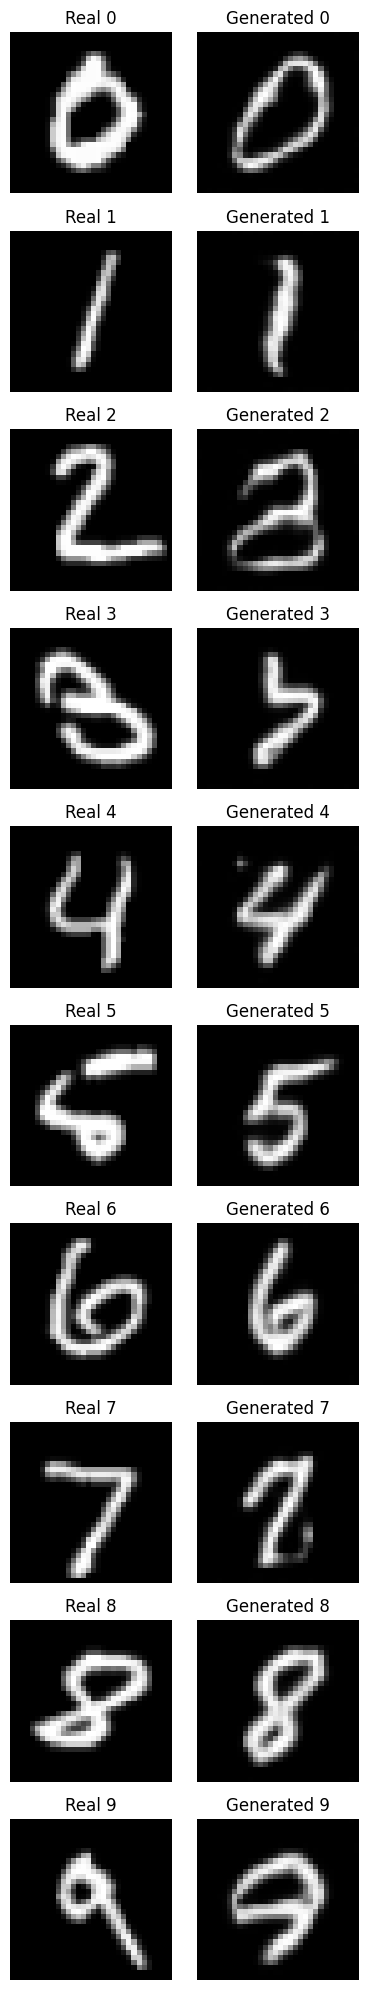

In [15]:
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
import torch
import os

# 모델 로드
vae.load_state_dict(torch.load(vae_model_path, map_location=device))
unet.load_state_dict(torch.load(unet_model_path, map_location=device))
vae.eval()
unet.eval()

# 스케줄러 설정
noise_scheduler = DDPMScheduler(num_train_timesteps=denoising_timesteps)

# 0~9 클래스에 대한 샘플 latent noise
latents = torch.randn((10, latent_channels, 8, 8)).to(device)
labels = torch.arange(10).to(device)

# DDPM reverse 과정
for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        noise_pred = unet(latents, t, class_labels=labels, encoder_hidden_states=None).sample
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        if t == 0:
            decoded = vae.decode(latents).sample
            decoded = decoded.cpu().detach()

# 정규화 해제 및 클램핑
decoded = decoded * 0.5 + 0.5
decoded = decoded.clamp(0, 1)

# === MNIST 원본에서 클래스별 하나씩 추출 ===
real_images = []
for i in range(10):
    for img, label in mnist_test:
        if label == i:
            real_images.append(img)
            break
real_images = torch.stack(real_images)  # (10, 1, 32, 32)

# 시각화: 각 행에 원본-생성 이미지 쌍
fig, axs = plt.subplots(10, 2, figsize=(4, 20))
for i in range(10):
    # 원본
    axs[i, 0].imshow(real_images[i][0], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Real {i}")

    # 생성
    axs[i, 1].imshow(decoded[i][0], cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Generated {i}")

plt.tight_layout()
plt.show()


In [ ]:
# main.py
from diffusers import DDPMScheduler
import torch

import os

def sample():
    if os.path.exists(unet_model_path) and os.path.exists(vae_model_path):
        vae.load_state_dict(torch.load(vae_model_path))
        unet.load_state_dict(torch.load(unet_model_path))
        noise_scheduler = DDPMScheduler(num_train_timesteps=denoising_timesteps)
        generate(vae, unet, noise_scheduler, 101)
    else:
        print("Models not trained, training...")
        train()

if __name__ == "__main__":
    create_path_if_not_exists('models')
    create_path_if_not_exists('plots')
    create_path_if_not_exists(vae_plots_path)
    create_path_if_not_exists(unet_plots_path)

    sample()